In [68]:
import torch

from torchvision import transforms

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from utils import DrawBbox

ConvertTensor=transforms.ToTensor()
DEVICE = torch.device('cpu')

# Detection using the trained faster RCNN

In [69]:
def load_Kitti_Trained_Model(modelPath, NUM_CLASSES, DEVICE=torch.device('cpu')):

    # load model's architecture
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    # load pretrained model
    checkpoint = torch.load(modelPath, map_location=DEVICE)

    # Get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [70]:
KITTI_INSTANCE_CATEGORY_NAMES = {0: u'Cyclist', 1: u'DontCare', 2: u'Misc', 3: u'Person_sitting', 4: u'Tram', 5: u'Truck', 6: 'Van', 7: u'car', 8: u'person'}

In [71]:
PATH="/home/aya/Desktop/Kitti_FasterRCNN/outputs/training/resultat/best_model.pth"
model=load_Kitti_Trained_Model(PATH,NUM_CLASSES=len(KITTI_INSTANCE_CATEGORY_NAMES))
model.to(DEVICE).eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [72]:
COLORS = np.random.uniform(0, 255, size=(len(KITTI_INSTANCE_CATEGORY_NAMES), 3))

In [73]:
# Read input image
input_img=cv2.imread("/home/aya/Desktop/Kitti_FasterRCNN/data/test/images/000346.png")
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) # Convert to RGB

In [74]:
#convert the PIL image to a tensor
Tensor_img = ConvertTensor(input_img)

In [75]:
import time
# Use the model for inference
#pass the image to the model
start_time = time.time()
with torch.no_grad(): #not to use the gradient function of pytorch (grad will not be calculated)
    pred=model([Tensor_img],)
end_time = time.time()

number of objects with 0.5 confidence: 11


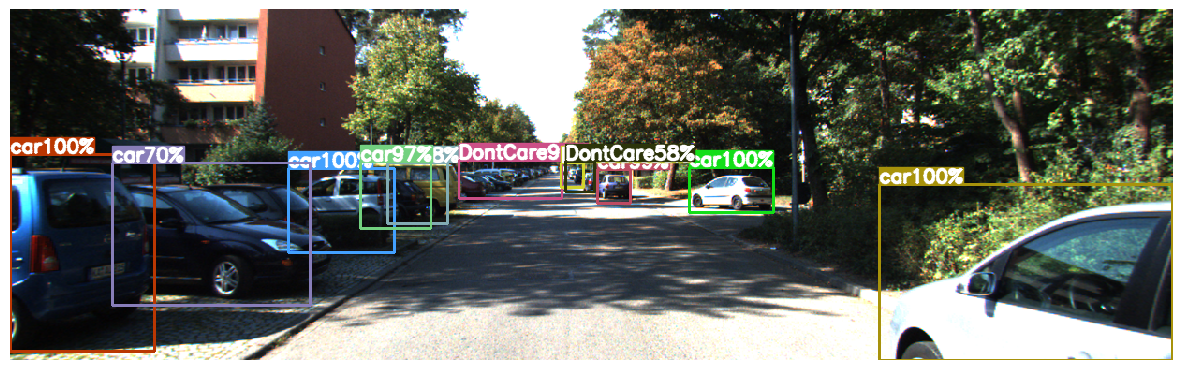

In [76]:
#Draw bboxes
DrawBbox(input_img,pred,KITTI_INSTANCE_CATEGORY_NAMES,0.5)

# Generate an Adversarial Attack

In [77]:
from art.attacks.evasion import DPatch
from art.estimators.object_detection import PyTorchFasterRCNN
from art.estimators.object_detection import PyTorchObjectDetector
from art.estimators.object_detection.object_detector import ObjectDetectorMixin

In [78]:
# # Create ART object detector
# frcnn = PyTorchObjectDetector(model,
#         clip_values=(0, 255), attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"],device_type="gpu"
#     )

In [79]:
# Create ART object detector
frcnn = PyTorchFasterRCNN(model,
        clip_values=(0, 255), attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"],device_type="cpu"
    )

In [80]:
def get_loss(frcnn, x, y):
    frcnn._model.train()
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    image_tensor_list = list()

    for i in range(x.shape[0]):
        if frcnn.clip_values is not None:
            img = transform(x[i] / frcnn.clip_values[1]).to(frcnn._device)
        else:
            img = transform(x[i]).to(frcnn._device)
        image_tensor_list.append(img)

    loss = frcnn._model(image_tensor_list, y)
    for loss_type in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
        loss[loss_type] = loss[loss_type].cpu().detach().numpy().item()
    return loss


def append_loss_history(loss_history, output):
    for loss in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
        loss_history[loss] += [output[loss]]
    return loss_history

In [81]:
img = cv2.resize(input_img, dsize=(input_img.shape[1], input_img.shape[0]), interpolation=cv2.INTER_CUBIC)
image = np.stack([img], axis=0).astype(np.float32)
print("image.shape:", image.shape)

image.shape: (1, 375, 1242, 3)


In [82]:
# Define attack parameters
patch_shape = (64, 64,3)  # Adjust the patch shape as needed
patch_location = (32, 32)  # Adjust the patch location as needed
crop_range = (0, 0)  # Adjust the crop range as needed
max_iter=1 #The number of optimization steps

attack = DPatch(
        frcnn,
        patch_shape=patch_shape,
        learning_rate=15.,
        max_iter=5000,
        batch_size=32

    )

In [83]:
# PATH="/home/aya/Desktop/Kitti_FasterRCNN/outputs/training/resultat(0-71epochs)/best_model.pth"
# model=load_Kitti_Trained_Model(PATH,NUM_CLASSES=len(KITTI_INSTANCE_CATEGORY_NAMES),DEVICE=frcnn._device)
# model.to(frcnn._device)

In [84]:
# Convert target boxes to fcnn device
for i, y_i in enumerate(pred):
        pred[i]["boxes"] = y_i["boxes"].type(torch.float).to(frcnn._device)
        pred[i]["labels"] = y_i["labels"].type(torch.int64).to(frcnn._device)
        pred[i]["scores"] = y_i["scores"].to(frcnn._device)

In [85]:
loss_history = {"loss_classifier": [], "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": []}

print("loss before the patch")
loss = get_loss(frcnn, image, pred)
print(loss)
loss_history = append_loss_history(loss_history, loss)

#APPLYING THE PATCH
patch = attack.generate(x=image,target_label=1)#param y is the True labels. Provided for untargated attacks y=pred
x_patch = attack.apply_patch(x=image)

print("loss after the patch")

loss = get_loss(frcnn, x_patch, pred)
print(loss)
loss_history = append_loss_history(loss_history, loss)

loss before the patch
{'loss_classifier': 0.4178708791732788, 'loss_box_reg': 0.4537091553211212, 'loss_objectness': 0.04618052393198013, 'loss_rpn_box_reg': 0.045926351100206375}


DPatch iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

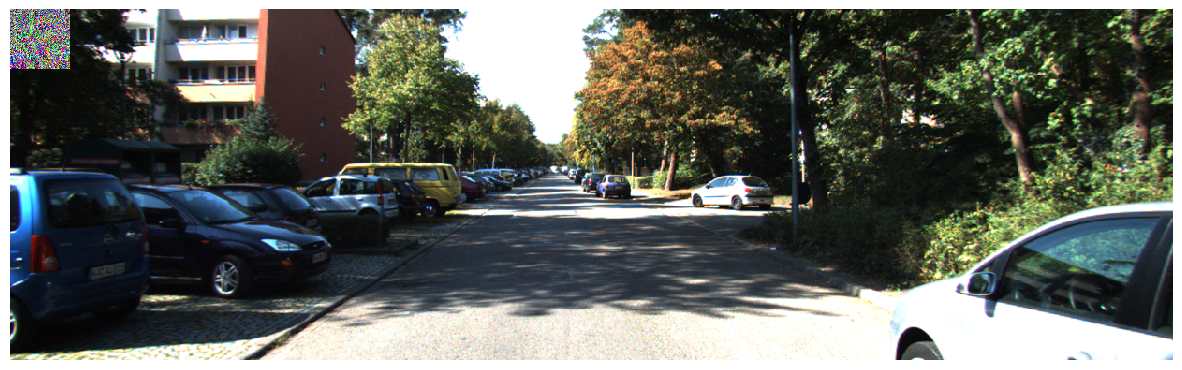

In [ ]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(x_patch[0].astype(np.uint8), interpolation="nearest")

In [ ]:
# save the image
img=x_patch[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("photo.png", img)

True

In [ ]:
img=Image.open("photo.png")
#convert the PIL image to a tensor
img = ConvertTensor(img)

#predict
model.eval().to(DEVICE)
with torch.no_grad(): #not to use the gradient function of pytorch (grad will not be calculated)
    pred=model([img],)
end_time = time.time()

number of objects with 0.5 confidence: 11


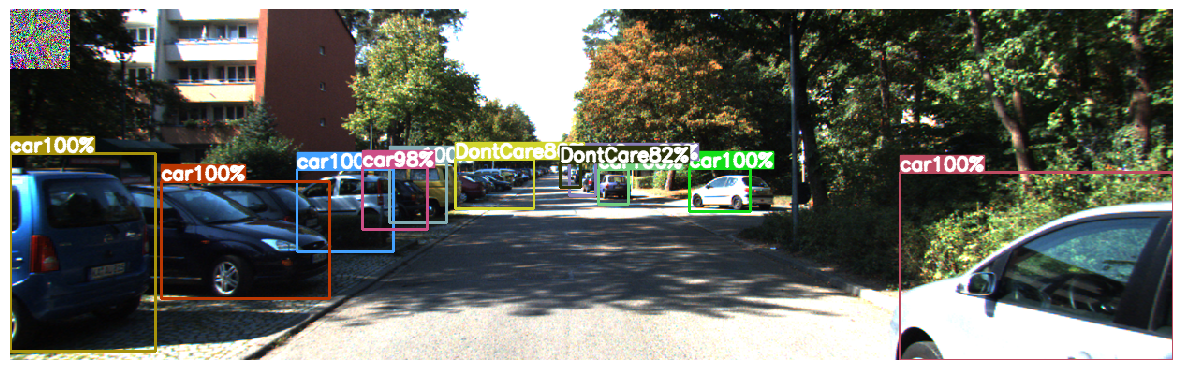

In [ ]:
#read the image in cv2
im=cv2.imread("photo.png")
# Convert to RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#Draw bboxes
DrawBbox(im,pred,KITTI_INSTANCE_CATEGORY_NAMES,0.5)